<a href="https://colab.research.google.com/github/Phistian/exjobb/blob/main/miguel/plotting/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup

In [1]:
import sys
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !git clone https://github.com/Phistian/exjobb
  !git config --global user.email "christianrut42@gmail.com"
  !git config --global user.name "Phistian"
  from google.colab import drive
  drive.mount('/content/drive')
  cur_path = Path("/content/exjobb/miguel/training")
else:
  cur_path = Path(__file__)


parent_path = cur_path.parent.resolve()
exjobb_address = str(parent_path) + "/../"
spatial_address = str(parent_path) + '/spatial_gnns/'
datasets_address = str(parent_path) + '/datasets/'
histories_address = str(parent_path) + '/training_results/saved_histories/'
models_address = str(parent_path) + '/training_results/saved_models/'
sys.path.append(spatial_address)
sys.path.append(str(parent_path))

Cloning into 'exjobb'...
remote: Enumerating objects: 1357, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 1357 (delta 240), reused 268 (delta 143), pack-reused 956
Receiving objects: 100% (1357/1357), 150.23 MiB | 14.04 MiB/s, done.
Resolving deltas: 100% (822/822), done.
Updating files: 100% (284/284), done.
Mounted at /content/drive


In [2]:
%matplotlib inline
!pip install deeptrack --quiet
from importlib import reload
import deeptrack as dt
from deeptrack.models.gnns.graphs import GetEdge
import pandas as pd
import numpy as np

import own_graphs
from own_graphs import GetEdge as custom_ge
from own_graphs import EdgeExtractor as custom_ee
from own_graphs import GraphExtractor as custom_graphE
from own_generators import GraphGenerator as custom_gg
import own_models
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
own_graphs = reload(own_graphs)
from copy import deepcopy
import logging
logging.disable(logging.WARNING)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 21.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load data

In [5]:
losses = []
vals = []

epoch_ends1 = ["200", "400", "1000"]
epoch_ends2 = ["300", "700", "1000"]
epoch_ends3 = ["300", "700", "1000"]
epoch_ends4 = ["1000"]


name_list = ["DATA1/", "DATA2/", "DATA3/", "DATA4/"]
epoch_ends_list = [epoch_ends1, epoch_ends2, epoch_ends3, epoch_ends4]
for i in range(4):
  dfs = []
  epoch_ends = epoch_ends_list[i]
  simulation_name = name_list[i]
  for i in range(len(epoch_ends)):
    df = pd.read_csv(histories_address + simulation_name + 'valhistory' + epoch_ends[i] + '.csv', sep=',', index_col=0)
    if i == 0:
      v = np.linspace(0, int(epoch_ends[i]), len(df))
      df["e"] = v
    else:
      v = np.linspace(int(epoch_ends[i-1]), int(epoch_ends[i]), len(df))
      df["e"] = v

    dfs.append(df)

  cdfval = pd.concat(dfs, axis=0)
  vals.append(cdfval)


for i in range(4):
  dfs = []
  epoch_ends = epoch_ends_list[i]
  simulation_name = name_list[i]
  for i in range(len(epoch_ends)):
    df = pd.read_csv(histories_address + simulation_name + 'losshistory' + epoch_ends[i] + '.csv', sep=',', index_col=0)
    if i == 0:
      v = np.linspace(0, int(epoch_ends[i]), len(df))
      df["e"] = v
    else:
      v = np.linspace(int(epoch_ends[i-1]), int(epoch_ends[i]), len(df))
      df["e"] = v

    dfs.append(df)

  cdfloss = pd.concat(dfs, axis=0)
  losses.append(cdfloss)

(0.0, 1000.0, -0.3, 8.0)

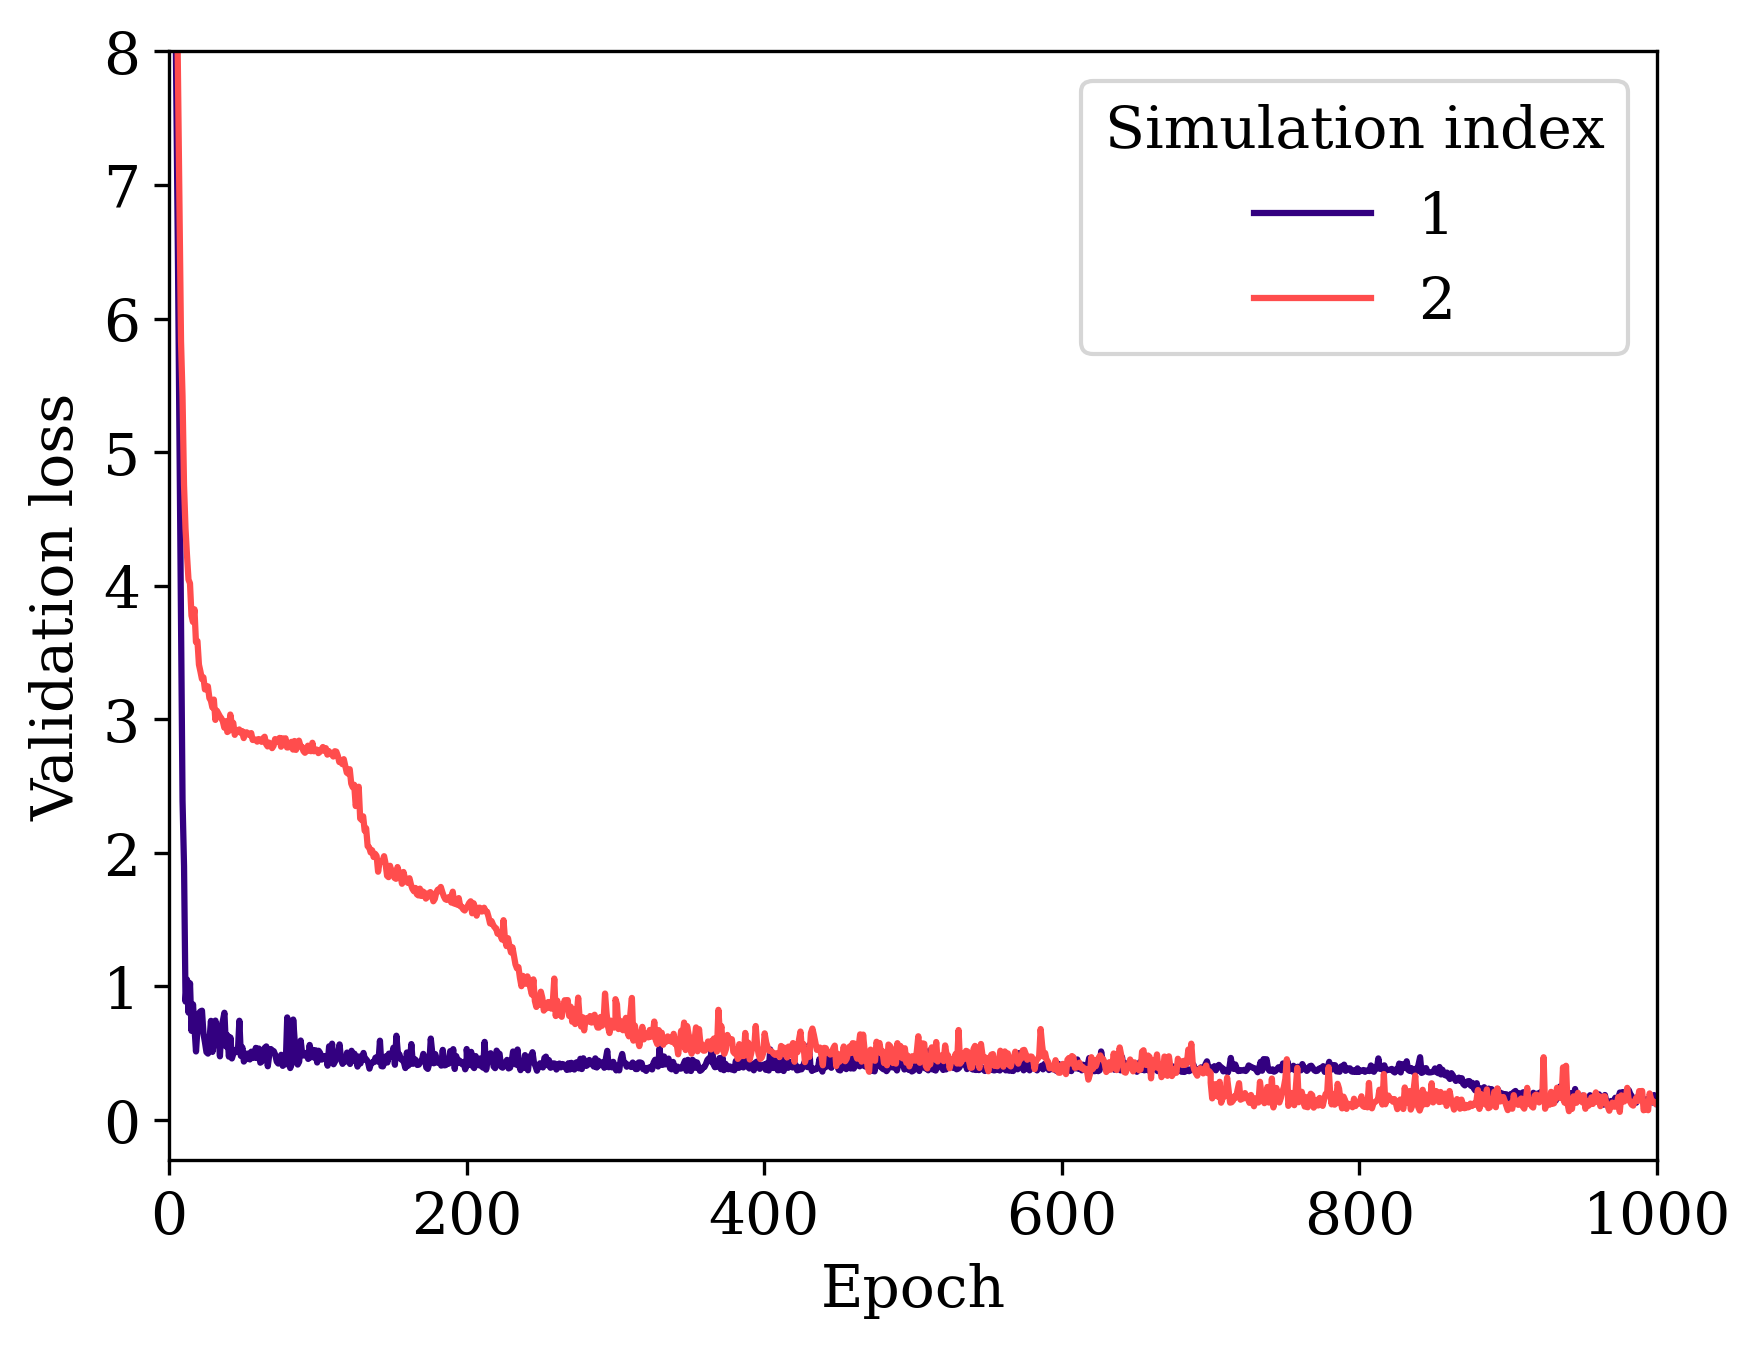

In [6]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['times new roman']
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})
color_v = [[0.2, 0, 0.5], [1, 0.3, 0.3], [0.2, 0, 0.5], [1, 0.3, 0.3]]
linestyle_v = ["dashed", "dotted", "dashdot", "solid"]
plt.figure(dpi=300)
for i in range(2):
  plt.plot(vals[i]["e"], vals[i]["0"], color = color_v[i])
plt.legend(["1", "2", "3", "4"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.axis([0,1000,-0.3, 8])


(0.0, 1000.0, -0.3, 8.0)

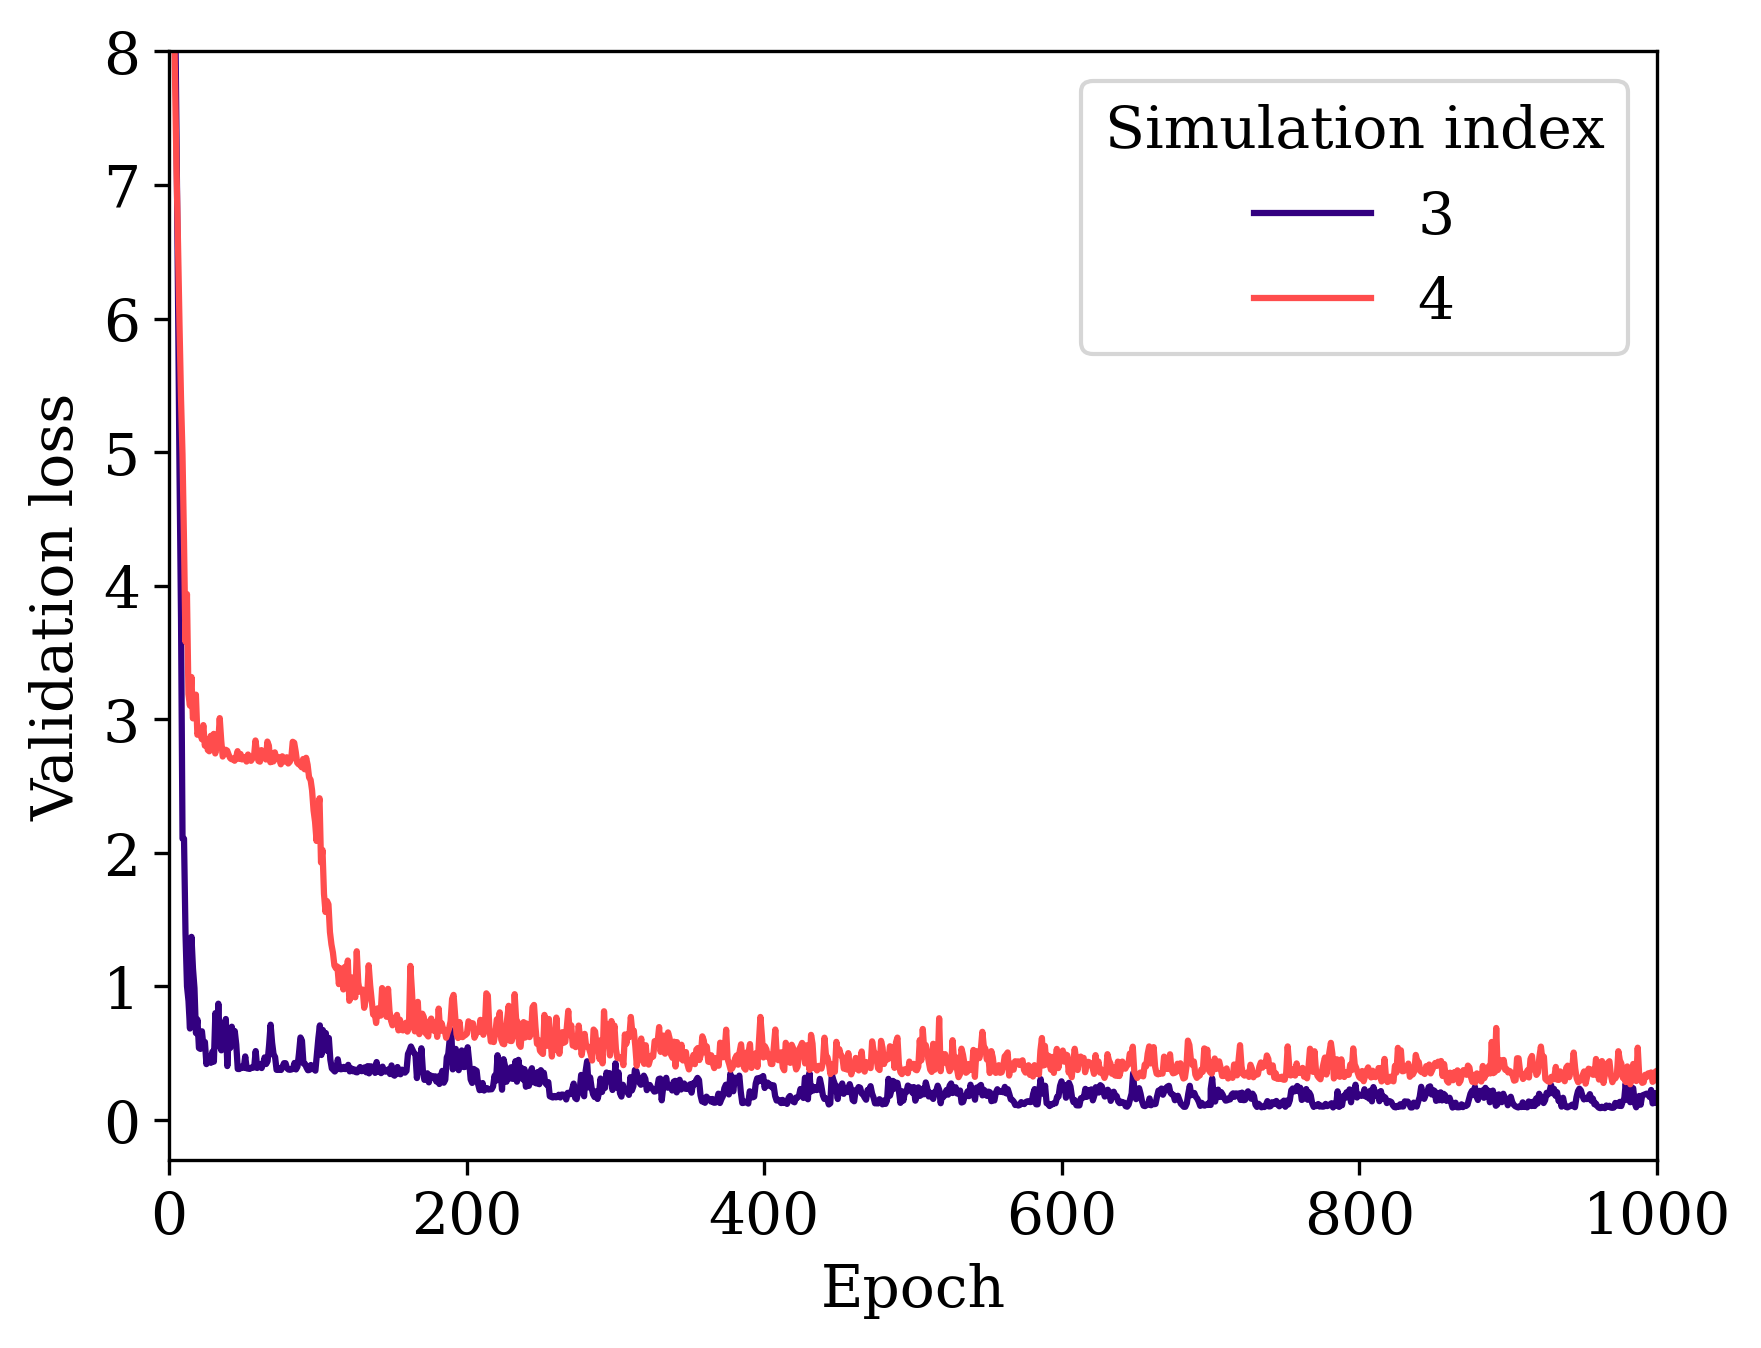

In [7]:
plt.figure(dpi=300)

for i in range(2,4):
  plt.plot(vals[i]["e"], vals[i]["0"], color = color_v[i])
plt.legend(["3", "4"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.axis([0,1000,-0.3, 8])

(0.0, 1000.0, -0.3, 8.0)

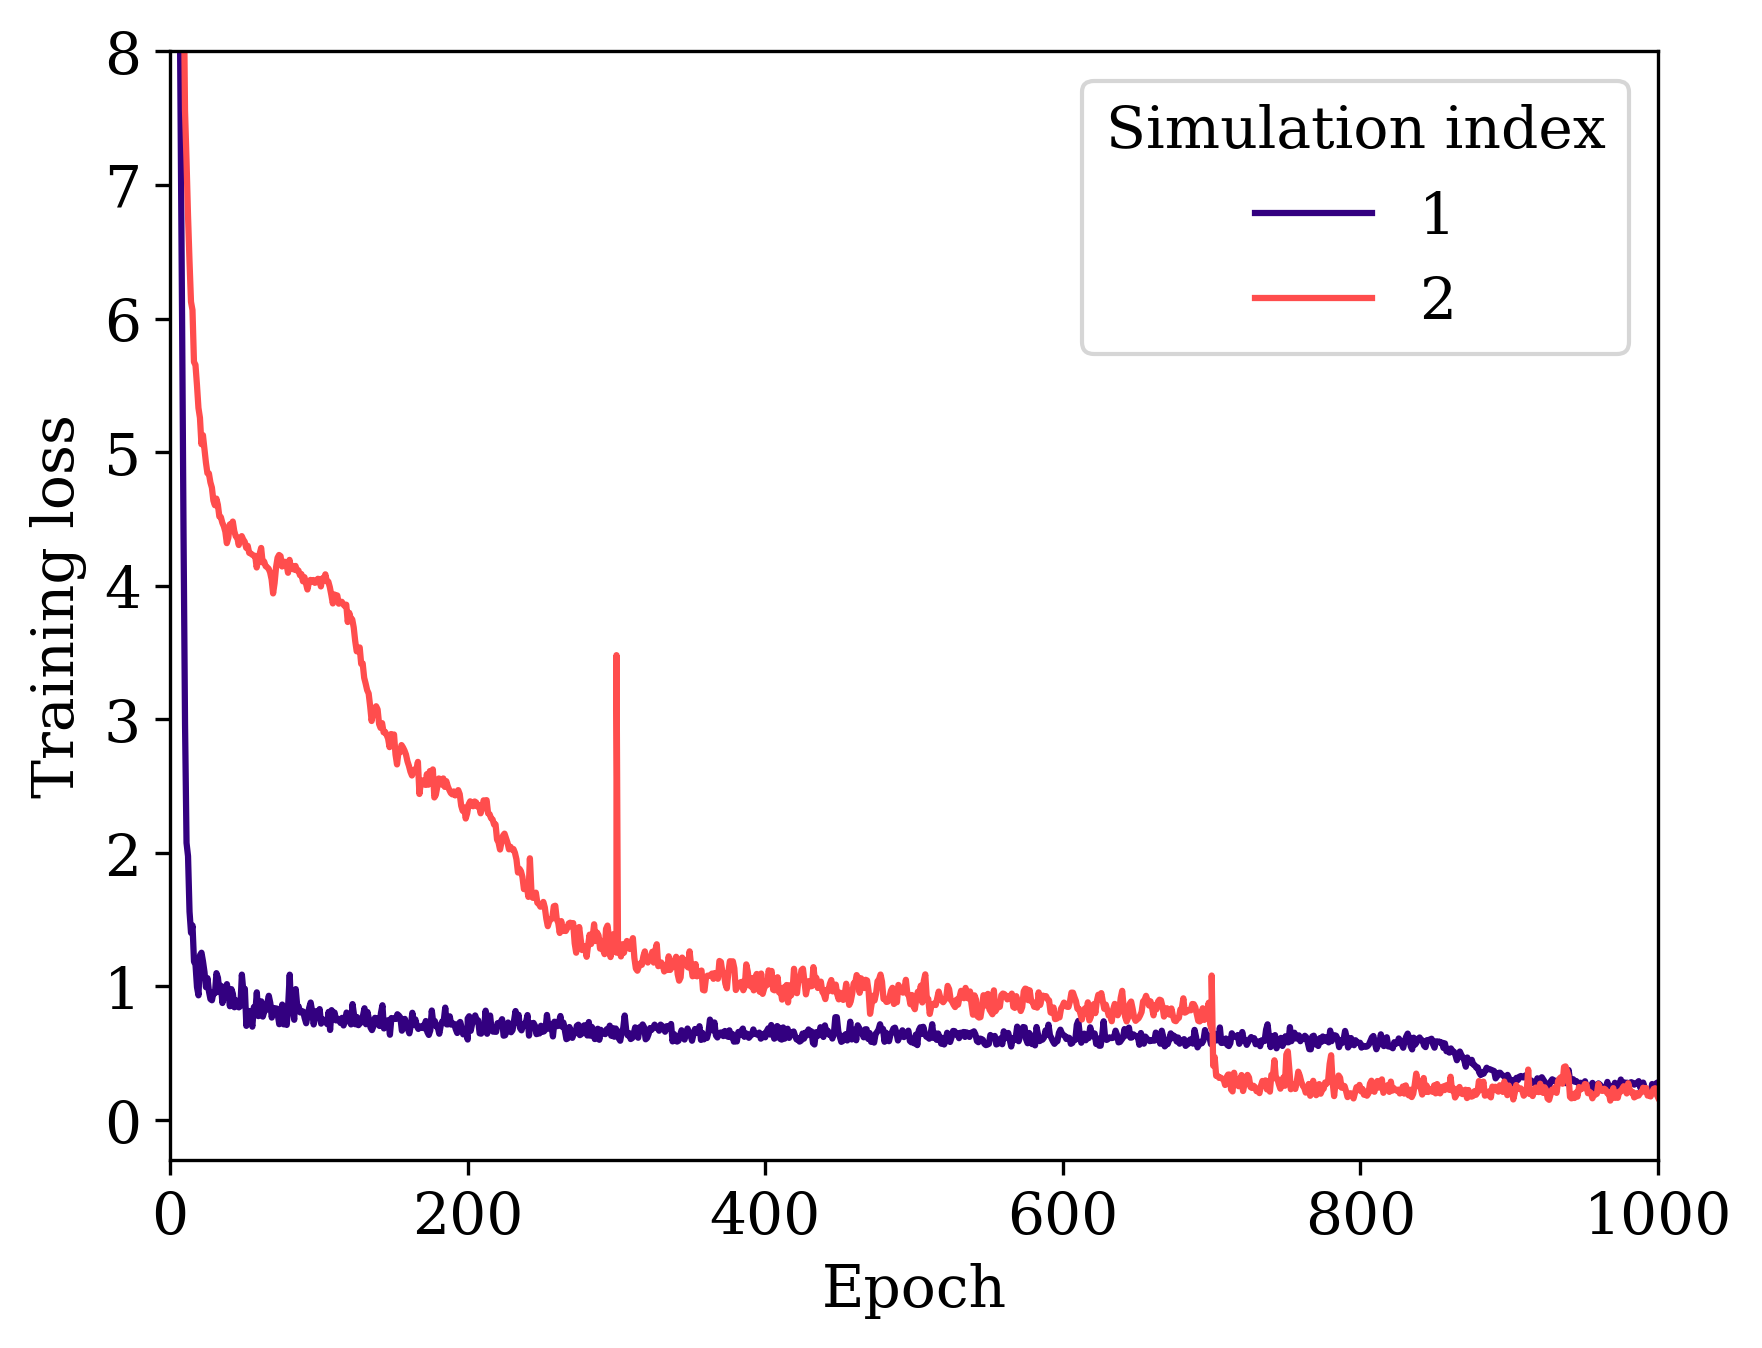

In [8]:
plt.figure(dpi=300)

for i in range(2):
  plt.plot(losses[i]["e"], losses[i]["loss"], color = color_v[i])
plt.legend(["1", "2"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.axis([0,1000,-0.3, 8])

(0.0, 1000.0, -0.3, 8.0)

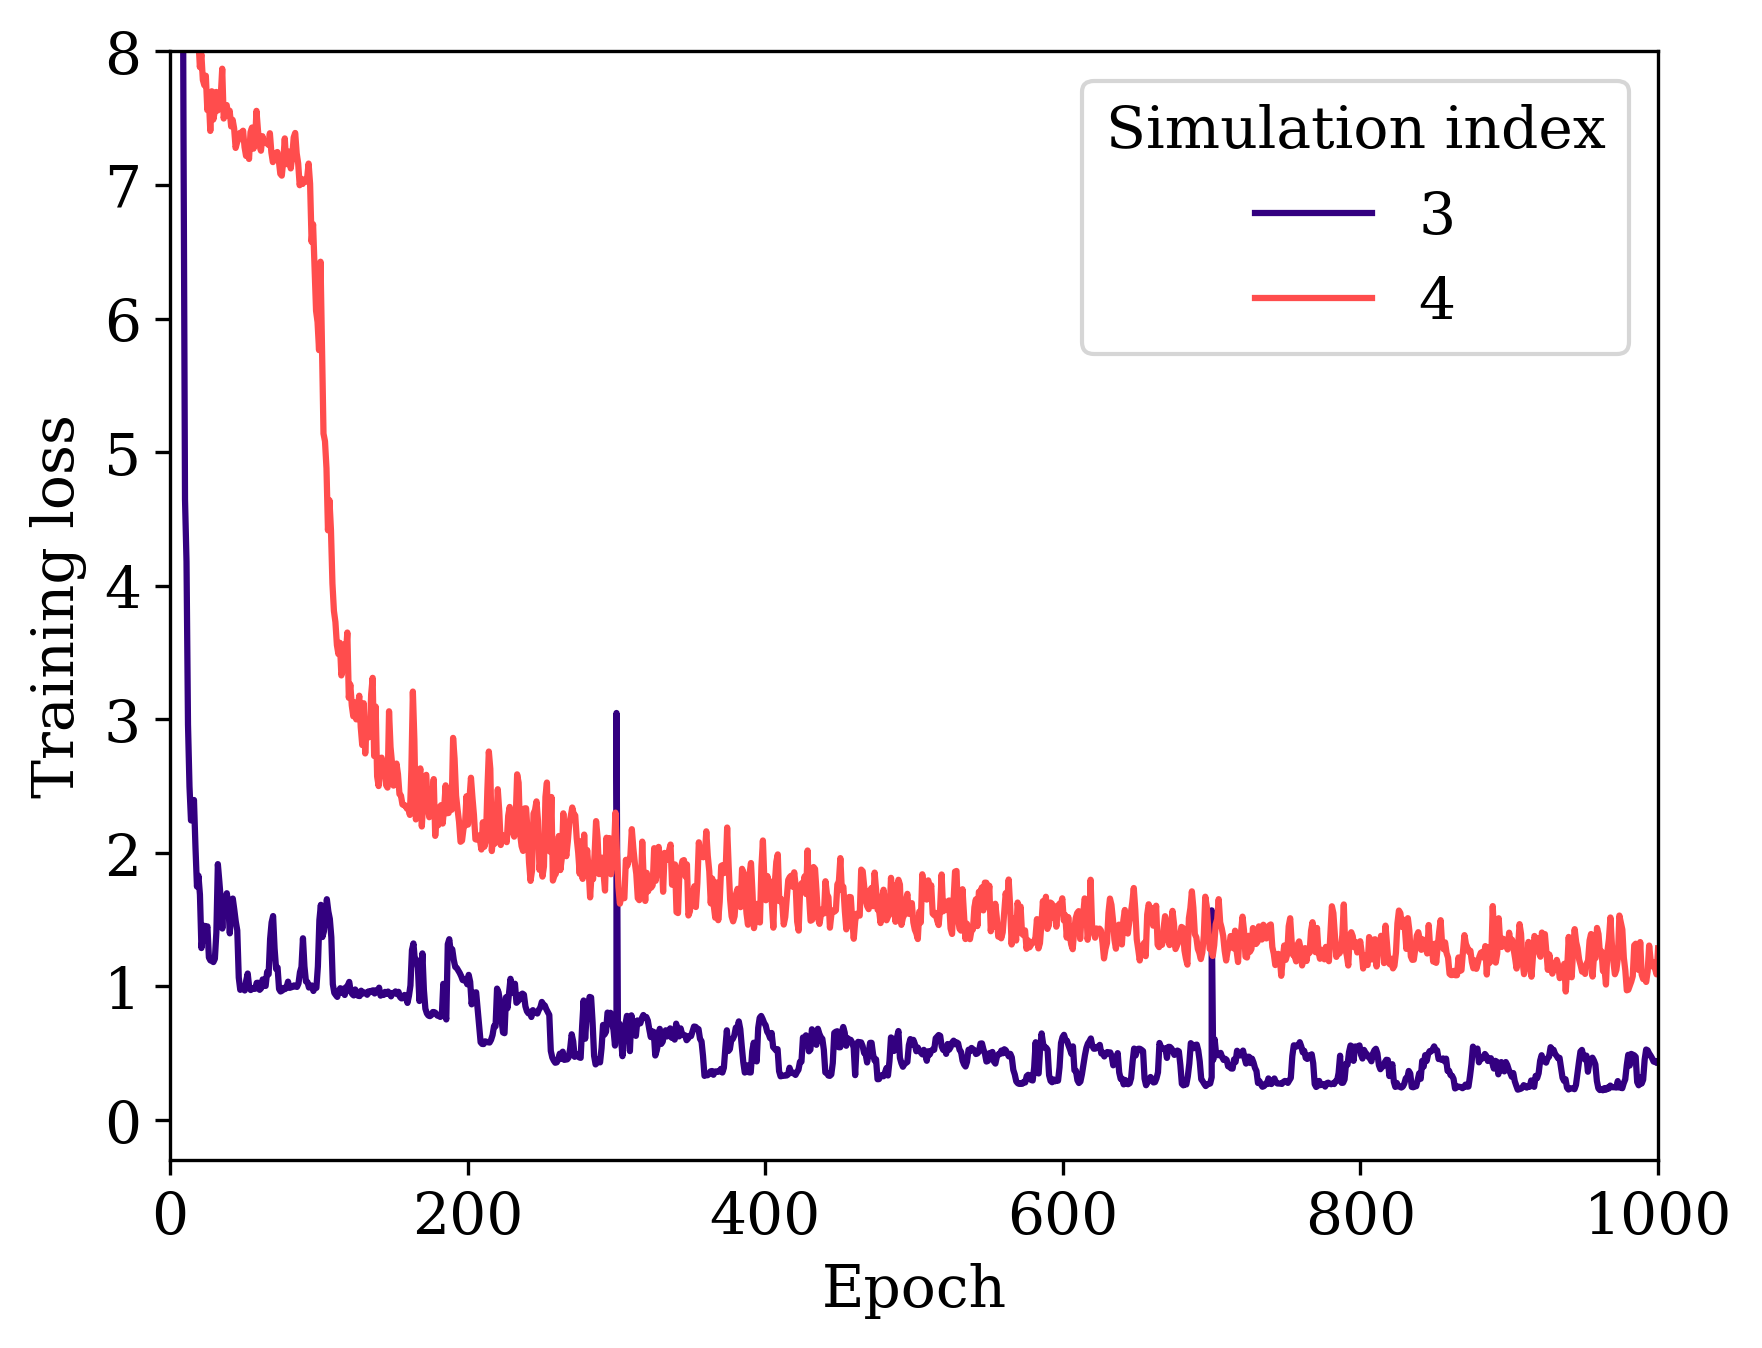

In [9]:
plt.figure(dpi=300)

for i in range(2,4):
  plt.plot(losses[i]["e"], losses[i]["loss"], color = color_v[i])
plt.legend(["3", "4"], title="Simulation index")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.axis([0,1000,-0.3, 8])


600